In [1]:
!pip install numpy==1.24.3 matplotlib opencv-python tensorflow



  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e3/f8/9246d3c7e185a29d7359d8b12b3d70bf2c3150ecf1427ec1382290e71a56/tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/a4/7d/f1c30a92854540bf789e9cd5dde7ef49bbe63f855b85a2e6b3db8135c591/opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Obtaining dependency information for gast!=0.5.

In [1]:
import zipfile
with zipfile.ZipFile('SolarPanelFaultyDetection.zip', 'r') as zip_ref:
    zip_ref.extractall()



In [6]:
import os

dataset_path = 'Faulty_solar_panel'  # Change if your folder name is different

# List main dataset folder contents (should show class subfolders)
print(f"Contents of '{dataset_path}':")
print(os.listdir(dataset_path))

# Optional: List contents of one class folder to verify images
first_class_folder = os.listdir(dataset_path)[0]
print(f"\nImages in class folder '{first_class_folder}':")
print(os.listdir(os.path.join(dataset_path, first_class_folder))[:5])  # Show first 5 images


Contents of 'Faulty_solar_panel':
['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']

Images in class folder 'Bird-drop':
['Bird (1).jpeg', 'Bird (10).jpg', 'Bird (100).jpg', 'Bird (101).jpg', 'Bird (102).jpg']


In [11]:
import os
import pandas as pd

dataset_path = 'Faulty_solar_panel'  # Your dataset folder name
labels = []

# List all class folders
class_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
print("Found class folders:", class_folders)

# Loop through all class folders properly
for class_folder in class_folders:
    folder_path = os.path.join(dataset_path, class_folder)
    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            relative_img_path = os.path.join(class_folder, img_name)
            labels.append({'filename': relative_img_path, 'label': class_folder})

# Create DataFrame and save CSV
df = pd.DataFrame(labels)
csv_filename = 'solar_fault_dataset_labels(1).csv'
df.to_csv(csv_filename, index=False)
print(f"CSV saved as {csv_filename}")
print(df['label'].value_counts())  # Show count of images per class


Found class folders: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
CSV saved as solar_fault_dataset_labels(1).csv
label
Clean                193
Bird-drop            191
Dusty                190
Snow-Covered         123
Electrical-damage    103
Physical-Damage       69
Name: count, dtype: int64


In [12]:
import pandas as pd

# Load CSV file
csv_path = 'solar_fault_dataset_labels(1).csv'
df = pd.read_csv(csv_path)

# Show first rows to confirm
print(df.head())

# Create label to index mapping
label_names = sorted(df['label'].unique())
label_to_index = {name: idx for idx, name in enumerate(label_names)}
print("Label to index mapping:", label_to_index)

# Add integer label column
df['label_index'] = df['label'].map(label_to_index)


                   filename      label
0   Bird-drop\Bird (1).jpeg  Bird-drop
1   Bird-drop\Bird (10).jpg  Bird-drop
2  Bird-drop\Bird (100).jpg  Bird-drop
3  Bird-drop\Bird (101).jpg  Bird-drop
4  Bird-drop\Bird (102).jpg  Bird-drop
Label to index mapping: {'Bird-drop': 0, 'Clean': 1, 'Dusty': 2, 'Electrical-damage': 3, 'Physical-Damage': 4, 'Snow-Covered': 5}


In [18]:
import pandas as pd
import tensorflow as tf
import pathlib

# Load CSV with image filenames and text labels
csv_path = 'solar_fault_dataset_labels.csv'  # Your CSV file
df = pd.read_csv(csv_path)

# Base directory containing the image folders
base_path = pathlib.Path('Faulty_solar_panel')  # Change as per your folder name

# Map string labels to integer indices
label_names = sorted(df['label'].unique())
label_to_index = {name: idx for idx, name in enumerate(label_names)}
df['label_index'] = df['label'].map(label_to_index)

# Create full path list as POSIX strings (with forward slashes)
image_paths = [str((base_path / fname).as_posix()) for fname in df['filename']]
labels = df['label_index'].values

# Create TensorFlow dataset from file paths and labels
path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
label_ds = tf.data.Dataset.from_tensor_slices(labels)
image_label_ds = tf.data.Dataset.zip((path_ds, label_ds))

# Function to load and preprocess each image
def load_and_preprocess_img(path, label):
    image_file = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_file, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalize pixels to [0,1]
    return image, label

# Map preprocessing function onto dataset, parallelize loading
dataset = image_label_ds.map(load_and_preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch dataset for training efficiency
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(df)) \
                 .batch(batch_size) \
                 .prefetch(tf.data.AUTOTUNE)

print(f"Dataset prepared with {len(df)} samples and classes: {label_to_index}")
print(f"Batch size: {batch_size}")

# Optional: iterate through one batch to verify
for images, labels in dataset.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)


Dataset prepared with 869 samples and classes: {'Bird-drop': 0, 'Clean': 1, 'Dusty': 2, 'Electrical-damage': 3, 'Physical-Damage': 4, 'Snow-Covered': 5}
Batch size: 32
Images batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the MobileNetV2 base model without the top layer, pretrained on ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model to prevent training its weights initially
base_model.trainable = False

# Add custom classification head for your 6 classes
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 classes in your dataset
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
# Train for 10 epochs
history = model.fit(dataset,
                    epochs=10)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - accuracy: 0.2107 - loss: 2.0805
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.5568 - loss: 1.1163
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.6743 - loss: 0.8829
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.7167 - loss: 0.7673
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.7393 - loss: 0.7237
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.7958 - loss: 0.5761
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.8404 - loss: 0.5261
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.8204 - loss: 0.5119
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.8356 - loss: 0.4844
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - accuracy: 0.8541 - loss: 0.4488


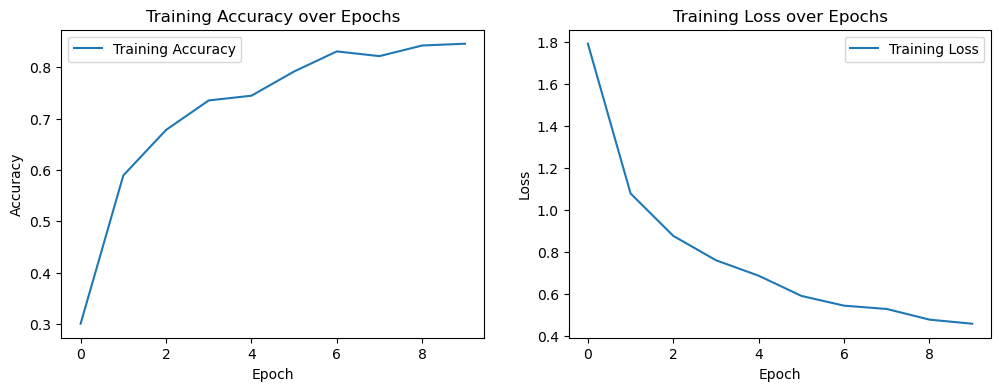

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.show()


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pathlib

# Load CSV
csv_path = 'solar_fault_dataset_labels(1).csv'
df = pd.read_csv(csv_path)

# Map labels to integers
label_names = sorted(df['label'].unique())
label_to_index = {name: idx for idx, name in enumerate(label_names)}
df['label_index'] = df['label'].map(label_to_index)

# Split into train and validation sets (80/20 split)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_index'], random_state=42)

base_path = pathlib.Path('Faulty_solar_panel')

def prepare_dataset(dataframe):
    image_paths = [str((base_path / fname).as_posix()) for fname in dataframe['filename']]
    labels = dataframe['label_index'].values
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((path_ds, label_ds))
    
    def load_and_preprocess_img(path, label):
        img_file = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img_file, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = img / 255.0
        return img, label
    
    dataset = dataset.map(load_and_preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_ds = prepare_dataset(train_df).shuffle(buffer_size=len(train_df)).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = prepare_dataset(val_df).batch(32).prefetch(tf.data.AUTOTUNE)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")


Training samples: 695, Validation samples: 174


In [25]:
# Unfreeze last 20 layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile with lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_epochs = 10
total_epochs = 20  # Assuming you trained 10 epochs before

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)


Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 499ms/step - accuracy: 0.5828 - loss: 1.1665 - val_accuracy: 0.8736 - val_loss: 0.3456
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.6186 - loss: 1.0169 - val_accuracy: 0.8678 - val_loss: 0.3564
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 402ms/step - accuracy: 0.7189 - loss: 0.8246 - val_accuracy: 0.8621 - val_loss: 0.3706
Epoch 13/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 401ms/step - accuracy: 0.7602 - loss: 0.7222 - val_accuracy: 0.8621 - val_loss: 0.3814
Epoch 14/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step - accuracy: 0.7915 - loss: 0.6496 - val_accuracy: 0.8621 - val_loss: 0.3905
Epoch 15/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 421ms/step - accuracy: 0.8145 - loss: 0.5836 - val_accuracy: 0.8563 - val_loss: 0.4012
Epoch 16/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 388ms/step - accuracy: 0.8310 - loss: 0.4978 - val_accuracy: 0.8276 - val_loss: 0.4027
Epoch 17/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.8599 - loss: 0.4901 - 